# TUTORIAL ON THE TOOLBOX `sLearningAndDiscretizationTools`

by Sebastian T. Glavind, May 2020

# Dynamic discretization and structure learning from partially observed data

This notebook considers how to use the toolbox `sLearningAndDiscretizationTools` to learn the graph structure (DAG) of a Bayesian network model and the corresponding optimal discretization policy of continuous variables. The toolbox is a wrapper for the [`bnlearn`](https://www.bnlearn.com/) package, see Scutari (2010), which implements the underlying routines for structure learning.

***
M. Scutari. Learning Bayesian Networks with the bnlearn R Package. Journal of Statistical Software, 35(3), 1-22, 2010. http://www.jstatsoft.org/v35/i03/.
***

## Prelude

In [24]:
library(bnlearn) # Package for learning bayesian networks
source("../MyToolboxes/sLearningAndDiscretizationTools.R") # load toolbox from source location

## Data

In this tutorial, we use the publicly available [sachs](https://www.bnlearn.com/book-crc/) data set.

### Raw data

In [25]:
DATA_org = read.table("../Discretize&sLearn/sachs.data.txt", header = T) # load continuous data set (data frame) from source location
DATA = DATA_org
nodes = names(DATA) # variable names

### Simulate missing data

In [26]:
m_DATA = as.matrix(DATA) # convert to matrix in order to perform matrix operations
m_n_D = length(m_DATA); # length of the unfolded array nrow*ncol
n_missing = floor(0.1*m_n_D) # no. of missing data (NB! make n_iss comply with this -> reduce by missing percentage)
id_missing = arrayInd(sample(m_n_D, size = n_missing, replace = F), dim(m_DATA)) # indeices of missing data
DATA[id_missing] = NA # convert input at these indices to NA

### Initialize discrete data

This block initializes the discrete data as the continuous data and the discretization policy (discretization boundary points).

In [27]:
dDATA = DATA;
BP_list = sapply(nodes, function(x) NULL); 

### Bounds for discretization

This block defines a list containing the lower and upper bound for the variables.

In [28]:
BP_list_bounds = list(); 
for (i in 1:length(nodes)){
  BP_list_bounds[[nodes[i]]] = c(-Inf, Inf); # upper and lower bounds for variable
} # //*FOR*// NB! All break points for Variables with pre-defined break points should be specified in this list.

### Variables for which the discretization should be ajusted dynamically (continuous variables)

We choose to discretize every second variable dynamically, i.e. the prior discretization is kept for the remaining variables.

In [29]:
var_con = nodes[seq(from = 2, to = 10, by = 2)] # continuous variables

Prior discretization for continuous variables.

In [30]:
n_breaks = 3; # boundery points in discretization 

# Iniitial discretization of continuous variables
res_quan_discC = quantile_discretizer_inclNA(data = DATA[var_con], n_breaks = n_breaks, 
                                             bp_list_bounds = BP_list_bounds[var_con]) # //*DISCRETIZER_TOOLS.R*//
dDATA[var_con] = res_quan_discC$d_data; # initial discretization
BP_list[var_con] = res_quan_discC$bp_list; # Initilize list of boundery points
for (var in var_con) { # remove irellevant information (attributes)
  attributes(BP_list[[var]]) = NULL
} # //*FOR*//

### Variables for which the discretization is not ajusted (discrete variables)

Define discrete variables as the remaining variables (not continuous).

In [31]:
var_dis = setdiff(nodes, var_con); # discrete variables

Prior discretization for discrete variables (this discretization is not updated in this example).

In [32]:
# Discrete variables
res_quan_discD = quantile_discretizer_inclNA(data = DATA[var_dis], n_breaks = n_breaks, 
                                             bp_list_bounds = BP_list_bounds[var_dis]) # //*DISCRETIZER_TOOLS.R*//
dDATA[var_dis] = res_quan_discD$d_data; # initial discretization
BP_list[var_dis] = res_quan_discD$bp_list; # Initilize list of boundery points
for (var in var_dis) { # remove irellevant information (attributes)
  attributes(BP_list[[var]]) = NULL
} # //*FOR*//

## Dynamic discretization and structure learning

The method we use is based on Monti and Cooper (1998), thus we assume that a data set is generated in two steps: First, an interval of a variable is selected from the distribution of the discrete variable. Second, the corresponding continuous value is drawn from a distribution over the interval. We then seek an optimal discrete representation of the original continuous data set while learning the graph structure. As the graph structure changes throughout the structure learning phase, the discretization is adjusted dynamically to maximize an objective function in a manner similar to that proposed in Friedman and Goldszmidt (1996). Thus, we start by learning the optimal discretization of an initial graph structure, which in turn is used to learn a new graph structure. These two steps are repeated until the score function converges to a local optimum. A similar scheme for combined structure learning and discretization is used in Vogel (2013). In our implementation, we use functionalities from the publicly available R package bnlearn (Scutari, 2010) to learn the structure of the graph, using the Bayesian Dirichlet equivalent score metric within a hill climbing or tabu search algorithm (see below), which are score-based learning algorithms. 

In order to learn a DAG from incomplete data, we employ a variant of the structural EM algorithm (Friedman,1997; Friedman,1998). In the E-step, we impute the missing (discrete) data based on their maximum a-posteriori estimates using the current BN, which is termed hard-assignment EM. In the M-step, we learn a new BN based on the imputed data set, see Scutari (2010) for further details.

***
S. Monti and G. F. Cooper, “A multivariate discretization method for learningbayesian  networks  from  mixed  data,”  inFourteenth  International  Conference  onUncertainty in Artificial Intelligence, 1998, pp. 404–413.

N. Friedman, and M. Goldszmidt, “Discretizing Continuous Attributes While Learning Bayesian Networks,” 13th International  conference on Machine Learning, Bari, Italy, July 3–6, 1996, pp. 157–165.

K. Vogel,  “Applications of bayesian networks in natural hazard assessments,”Ph.D. dissertation, University of Potsdam, 2013., https://d-nb.info/1048476014/34, Accessed May 25, 2020.

N. Friedman, “Learning belief networks in the presence of missing values and
hidden variables,” in Fourteenth International Conference on Machine Learning,
1997, pp. 125–133.

N. Friedman, “The bayesian structural em algorithm,” in Fourteenth conference on Uncertainty
in artificial intelligence. Morgan Kaufmann Publishers Inc., 1998, pp.
129–138.

M. Scutari. Learning Bayesian Networks with the bnlearn R Package. Journal of Statistical Software, 35(3), 1-22, 2010. http://www.jstatsoft.org/v35/i03/.
***

### Algorithm selection

In [33]:
score_name = 'bde'; # Score to use in calculation of global scores. Options: 'bic' and 'bde' ('bds', 'mbde', 'bdj')
L = 1; # Parameters (default == 1, corr. to 'score_con' == 'vogel'). L < 1 (defaule == 1) may be used with 'score_con' == 'monti'
quiet = T; # Iff = FALSE, print progress report (related to discretize_all_oneIt)
score_con = 'vogel'; # 'vogel' Vogel(2013) or 'monti' Monti&Cooper(1998)
search_alg = 'hill'; # 'hill' for 'hill-climbing' and 'tabu' for tabu-search
imp_method = "parents" # Imputation method: "bayes-lw" (final assessments), "parents" (fast)

### Imaginary sample size for Dirichlet prior

In [34]:
# # Imaginary sample size
n_iss = 1 # current recommendation, see Ueno (2010)

***
M.  Ueno,  “Learning  networks  determined  by  the  ratio  of  prior  and  data,”  inIn Proceedings of 26th Conference Conference on Uncertainty in Artificial Intelligence, 2010, pp. 1–8
***

### Network initialization and constraints

In [35]:
# Network used to initialize search algorithm 
# see the bnlearn manual (https://www.bnlearn.com/)
# net_start = bn.fit(empty.graph(nodes), dDATA)
net_start = NULL

# Whitlist and Blacklist of connections
wl = NULL; # wl = data.frame(from = c("PIP2"), to = c("plcg"))
bl = NULL; # bl = data.frame(from = c("PKC", "P38"), to = c("P38", "PKC"))

### Learn discretization and DAG

- score_name_g: Global score (full network) - should be the same as score_name_l
- score_name_l: Local score (local Markov blankets) - should be the same as score_name_g
- L: Parameter for weighting the continuous likelihood compared to the discrete part (prior and likelihood)
- quiet: Print progress report, Iff = FALSE (related to discretize_all_oneIt)
- score_con: Continuous likelihood formulation, 'vogel' Vogel(2013) or 'monti' Monti&Cooper(1998)
- search_alg: Search strategy, 'hill' for 'hill-climbing' and 'tabu' for tabu-search
- DATA: Continuous data (data frame)
- dDATA: Discrete data (data frame)
- BP_list: List of boundery points for discretization policy
- BP_list_bounds: Upper and lower bound for BP_list
- n_iterations_loc_max: Maximum number of boundery points for the continuous variables
- var_con: Names of continuous variables (string vector), which needs dynamic discretization
- net_start: Initial network structure
- WL: White listed connections in network structure - forced connections
- BL: Black listed connections in network structure - forced, missing connections
- n_iss: Imaginary sample size for Dirichlet prior

In [36]:
# Learn discretization and network - with default bounds on the number of discretization points
RES1 = discretizeANDlearn_all_inclNA(score_name_g=score_name, score_name_l=score_name, L=L, quiet=quiet, 
                                     score_con=score_con, search_alg=search_alg, imp_method=imp_method, 
                                     DATA=DATA, dDATA=dDATA, BP_list=BP_list, BP_list_bounds=BP_list_bounds,            
                                     var_con=var_con, net_start=net_start, WL = wl, BL = bl, n_iss=n_iss)

In [37]:
# Learn discretization and network - with custom bounds on the number of discretization points

# Maximum number of additional BPs (BP_list_bounds + add BPs) of the continuous variables 
maxInt_list = vector(length(var_con), mode = 'list'); names(maxInt_list) = var_con; # individual restrictions (names list)
maxInt_list$pmek = 2; # max 3 states (upper and lower bound + 2 BP)
maxInt_list$PIP2 = 1; # max 2 states (binary)
maxInt_list$p44.42 = 1; # max 2 states (binary)
maxInt_list$PKA = 1; # max 2 states (binary)
maxInt_list$P38 = 1; # max 2 states (binary)

RES2 = discretizeANDlearn_all_inclNA(score_name_g=score_name, score_name_l=score_name, L=L, quiet=quiet, 
                                     score_con=score_con, search_alg=search_alg, imp_method=imp_method, 
                                     DATA=DATA, dDATA=dDATA, BP_list=BP_list, BP_list_bounds=BP_list_bounds, 
                                     n_iterations_loc_max = maxInt_list,            
                                     var_con=var_con, net_start=net_start, WL = wl, BL = bl, n_iss=n_iss)

### Show results

Plot DAG

[1] "with default bounds on the number of discretization points"


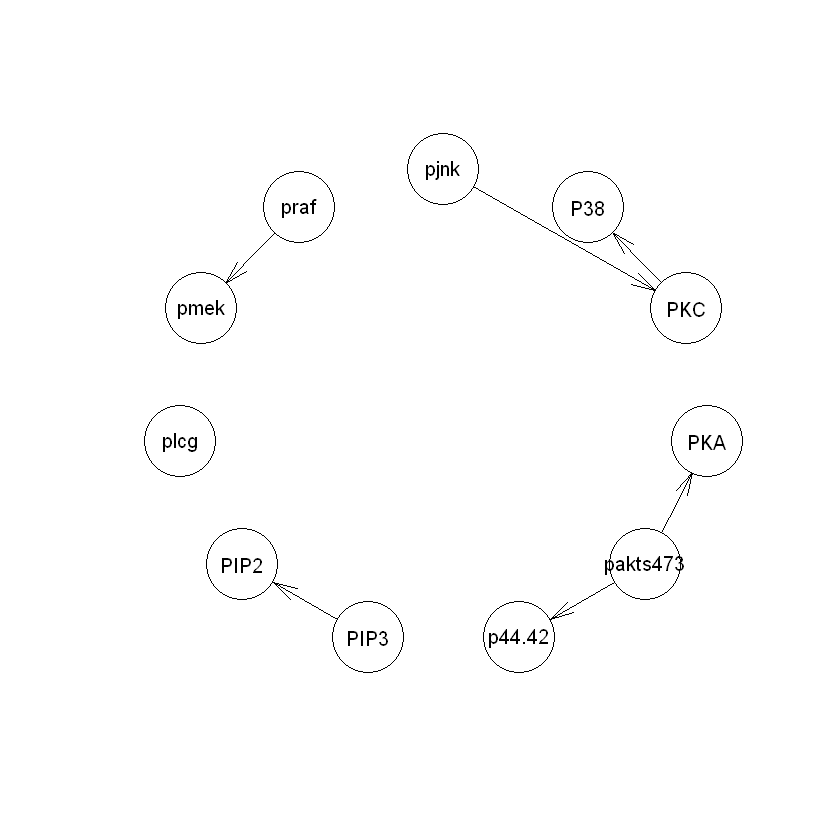

In [38]:
print('with default bounds on the number of discretization points')
plot(RES1$BN)

[1] "with custom bounds on the number of discretization points"


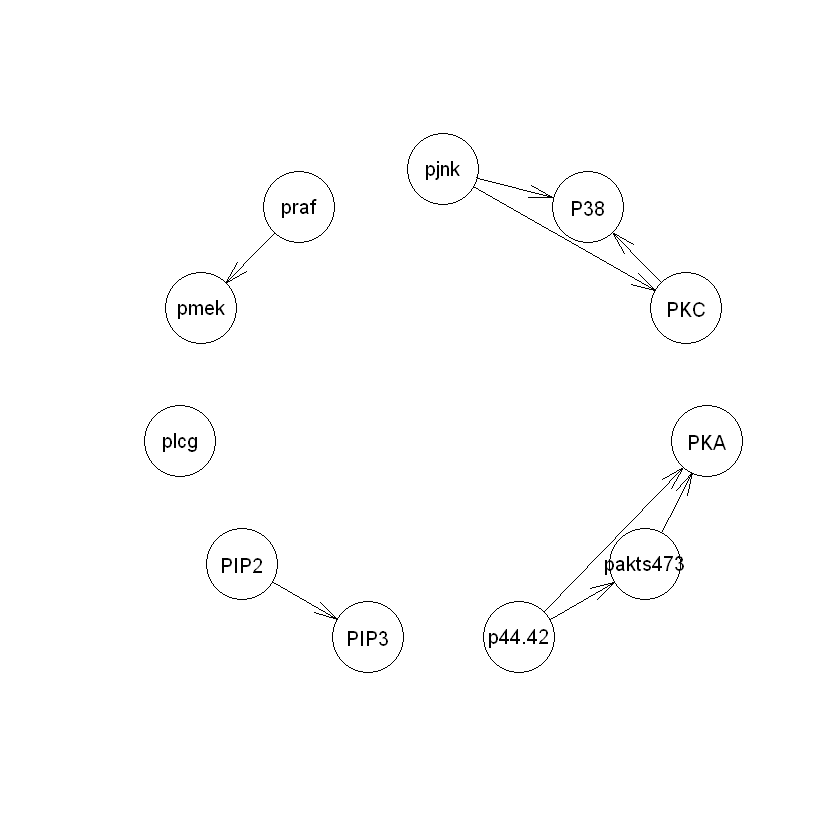

In [39]:
print('with custom bounds on the number of discretization points')
plot(RES2$BN)

Show discrete, hard-assignment imputed data set

In [40]:
print('with default bounds on the number of discretization points')
summary(RES1$dDATAimp, maxsum = 20)

print('with custom bounds on the number of discretization points')
summary(RES2$dDATAimp, maxsum = 20)

[1] "with default bounds on the number of discretization points"


          praf              pmek              plcg              PIP2    
 (-Inf,41]  :345   (-Inf,15.6]:134   (-Inf,13.6]:342   (-Inf,58.5]:513  
 (41,64.9]  :254   (15.6,24.2]:301   (13.6,21.1]:257   (58.5,150] :232  
 (64.9, Inf]:254   (24.2,38]  :274   (21.1, Inf]:254   (150, Inf] :108  
                   (38, Inf]  :144                                      
                                                                        
          PIP3             p44.42           pakts473           PKA     
 (-Inf,16.4]:343   (-Inf,9.18]:307   (-Inf,22.7]:303   (-Inf,194]: 39  
 (16.4,32.5]:257   (9.18,15.1]:177   (22.7,35.5]:289   (194,394] :299  
 (32.5, Inf]:253   (15.1,24.9]:226   (35.5, Inf]:261   (394,701] :318  
                   (24.9, Inf]:143                     (701, Inf]:197  
                                                                       
          PKC               P38               pjnk    
 (-Inf,8.77]:282   (-Inf,18.2]:149   (-Inf,14.7]:259  
 (8.77,18.2]:282   (

[1] "with custom bounds on the number of discretization points"


          praf              pmek              plcg            PIP2    
 (-Inf,41]  :261   (-Inf,17.6]:212   (-Inf,13.6]:342   (-Inf,48]:415  
 (41,64.9]  :338   (17.6,30.1]:362   (13.6,21.1]:257   (48, Inf]:438  
 (64.9, Inf]:254   (30.1, Inf]:279   (21.1, Inf]:254                  
          PIP3             p44.42           pakts473           PKA     
 (-Inf,16.4]:255   (-Inf,14.4]:410   (-Inf,22.7]:327   (-Inf,701]:679  
 (16.4,32.5]:345   (14.4, Inf]:443   (22.7,35.5]:258   (701, Inf]:174  
 (32.5, Inf]:253                     (35.5, Inf]:268                   
          PKC               P38               pjnk    
 (-Inf,8.77]:273   (-Inf,33.5]:506   (-Inf,14.7]:346  
 (8.77,18.2]:285   (33.5, Inf]:347   (14.7,33.7]:254  
 (18.2, Inf]:295                     (33.7, Inf]:253  

Compare discrete representation to continuous representation (kernel density), e.g. variable "pmek"

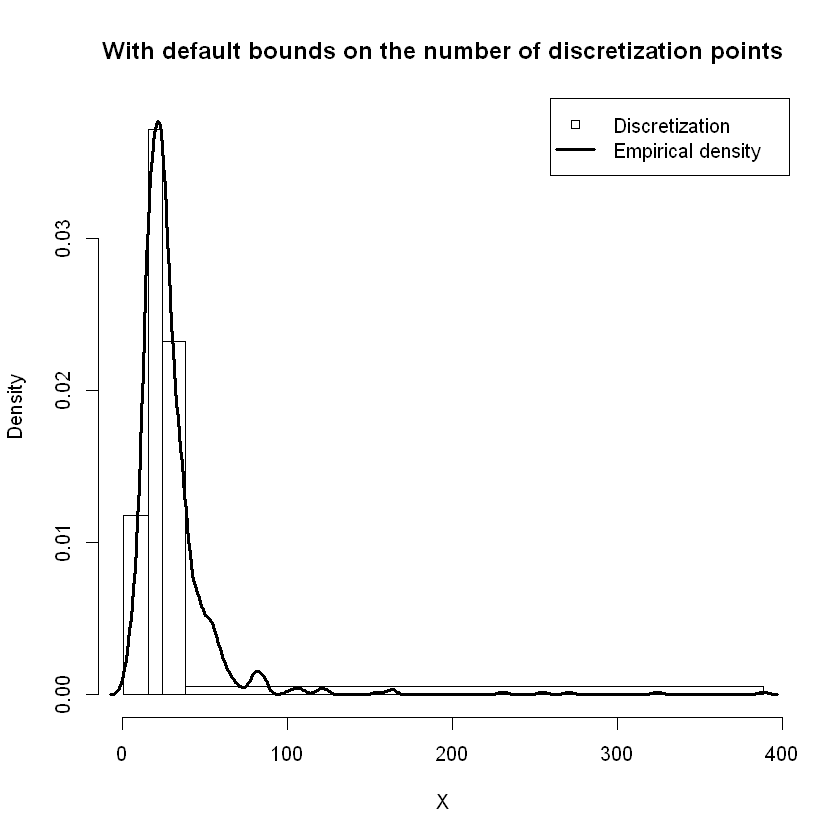

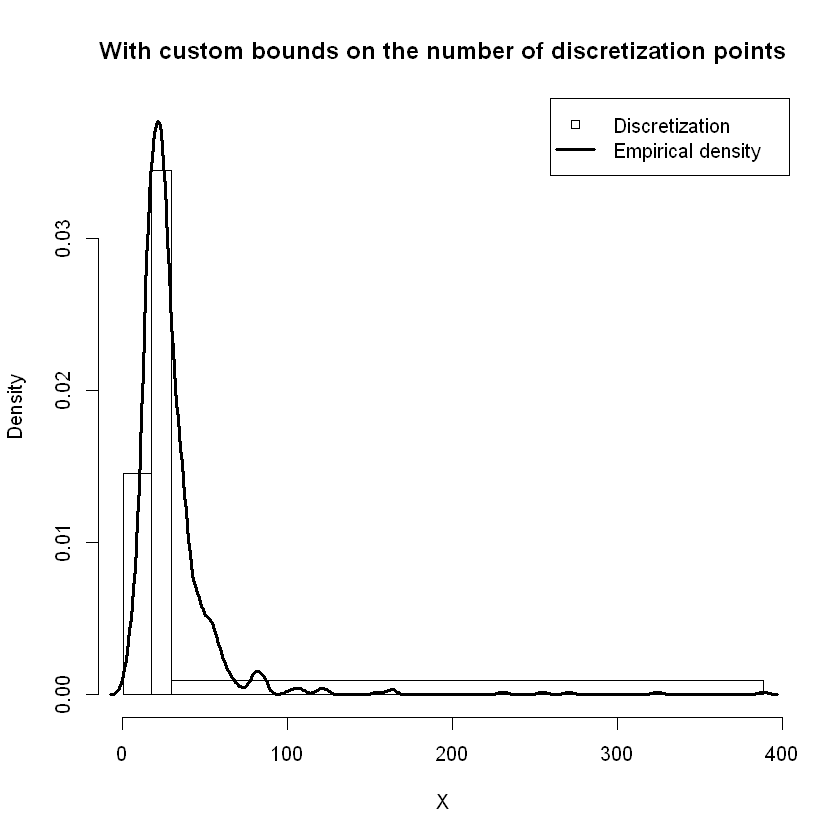

In [41]:
X = DATA_org$pmek # define (continuous) variable to plot, e.g. pmek
bpX = RES1$BP_list$pmek; bpX[1] = min(X); bpX[length(bpX)] = max(X) # define discretization bounderies (end point should have a finite value when plotting)
D = density(X)
H = hist(X, bpX, ylim=c(0,max(D$y)), main='With default bounds on the number of discretization points')
lines(D$x,D$y,lwd = 3)
legend('topright', legend = c('Discretization', 'Empirical density'),
       lwd = c(1,3), lty = c(NA,1), pch = c(22, NA))

bpX = RES2$BP_list$pmek; bpX[1] = min(X); bpX[length(bpX)] = max(X) # define discretization bounderies (end point should have a finite value when plotting)
D = density(X)
H = hist(X, bpX, ylim=c(0,max(D$y)), main='With custom bounds on the number of discretization points')
lines(D$x,D$y,lwd = 3)
legend('topright', legend = c('Discretization', 'Empirical density'),
       lwd = c(1,3), lty = c(NA,1), pch = c(22, NA))